In [1]:
import os
import random
from glob import glob
import numpy as np
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

In [2]:
data_path = 'D:/TugasAkhir/DataSet/MoNuSAC_images_and_annotations'
masks_path = 'D:/TugasAkhir/DataSet/MoNuSAC_masks_New'

In [3]:
type_label = {1:'Epithelial',
              2:'Lymphocyte',
              3:'Macrophage',
              4:'Neutrophil',
             }

In [4]:
data_ids = next(os.walk(data_path))  # tuple: for taking the directory and assign it as the IDs
data_ids = data_ids[1] # list
data_ids[:5]

['TCGA-55-1594-01Z-00-DX1',
 'TCGA-5P-A9K0-01Z-00-DX1',
 'TCGA-69-7760-01Z-00-DX1',
 'TCGA-69-A59K-01Z-00-DX1',
 'TCGA-73-4668-01Z-00-DX1']

In [5]:
print("Total subjects: ", len(data_ids))

Total subjects:  46


In [6]:
collect_images=[]
collect_masks_binary=[]
for patient_id in data_ids:
    #print(patient_id)
    img_paths = sorted(glob(os.path.join(data_path, patient_id, '*.tif')))
    for img_path in img_paths:
        #print(img_path) # each images
        img_id = img_path[len(data_path) + len(patient_id) +2:-4]
        #print(img_id)
        
        img = io.imread(img_path)
        img = img[:,:,:3] # remove channel 4, the alpha parameter (not important)
        bin_path = os.path.join(masks_path, patient_id, img_id)
        #print(bin_path)
        
        masks = np.zeros((img.shape[0], img.shape[1], 4), dtype='uint8')
        for i in range(4):
            label_code = i+1
            dir_mask = os.path.join(bin_path, type_label[label_code])
            #print(dir_mask)
            sub_masks = glob(dir_mask+'/*.tif')
            #print(sub_masks)
            if len(sub_masks)!=0:
                #print(sub_masks[0])
                mask = io.imread(sub_masks[0])
                masks[:,:,i] = mask
        
        collect_images.append(img)
        collect_masks_binary.append(masks)

In [7]:
print(len(collect_images))
print(len(collect_masks_binary))

209
209


In [8]:
print(collect_images[0].shape)
print(collect_masks_binary[0].shape)

(1024, 1024, 3)
(1024, 1024, 4)


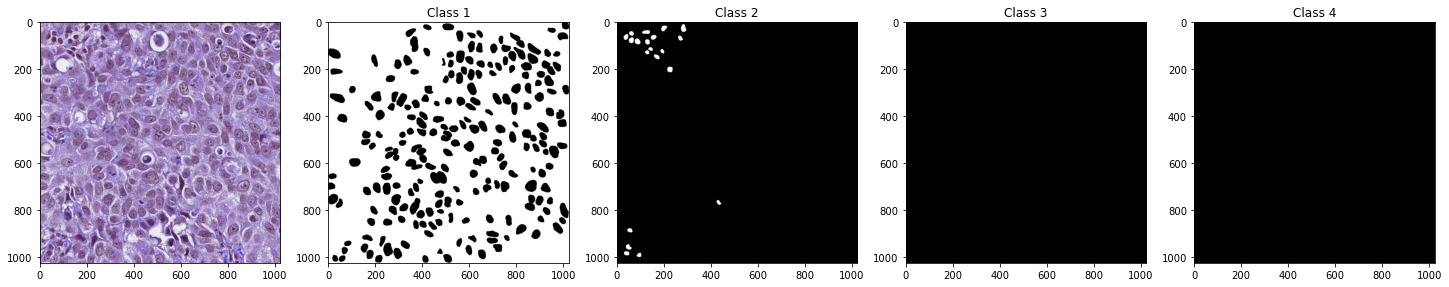

In [10]:
ind_case = 0
plt.figure(figsize=(25,5))
plt.subplot(1,5,1)
plt.imshow(collect_images[ind_case])
plt.subplot(1,5,2)
plt.imshow(collect_masks_binary[ind_case][:,:,0], cmap='binary');
plt.title('Class 1')
plt.subplot(1,5,3)
plt.imshow(collect_masks_binary[ind_case][:,:,1], cmap='gray');
plt.title('Class 2')
plt.subplot(1,5,4)
plt.imshow(collect_masks_binary[ind_case][:,:,2], cmap='gray');
plt.title('Class 3')
plt.subplot(1,5,5)
plt.imshow(collect_masks_binary[ind_case][:,:,3], cmap='gray');
plt.title('Class 4')
plt.show()

In [11]:
def start_points(size, split_size, overlap=0):
    points=[0]
    stride = int(split_size * (1-overlap))
    counter = 1
    while True:
        pt = stride * counter
        if pt + split_size >= size:
            points.append(size - split_size)
            break
        else:
            points.append(pt)
        counter +=1
    return points

In [12]:
poin = start_points(580, 256) # tetap ada overlap juga pada split yang terakhir
print(poin)
poin = start_points(580, 256, 0.5)
print(poin)

[0, 256, 324]
[0, 128, 256, 324]


In [13]:
def determine_split_size(img_array):
    img_h, img_w = img_array.shape[:2]
    
    if(img_h >=256 and img_w >=256):
        split_size = 256
    elif (img_h < 128 or img_w < 128):
        split_size = 64
    else:
        split_size = 128
    return split_size

In [14]:
split_size = determine_split_size(collect_images[1])
print(split_size)
split_size = determine_split_size(collect_images[123])
print(split_size)

256
64


In [15]:
def crop_image(img_array, crop_size, overlap=0):
    img_h, img_w = img_array.shape[:2]
    row_points = start_points(img_h, crop_size, overlap=overlap)
    col_points = start_points(img_w, crop_size, overlap=overlap)
    cropped_image=[] # create empty list first
    for i in row_points:
        for j in col_points:
            img_split = img_array[i:i+crop_size, j:j+crop_size, :]
            cropped_image.append(img_split)
            
    # convert list to array
    cropped_image_array = np.array(cropped_image)
    return cropped_image_array

In [16]:
def resize_multi_image(cropped_source, target_size=(256,256), thres=None):
    # thres digunakan untuk citra mask, biasanya thres=127
    if len(cropped_source.shape) > 3: # misalnya 4 x 128 x 128 x 3
        combine_crop=[]
        for i in range(cropped_source.shape[0]):
            crop = resize_multi_image(cropped_source[i], target_size=target_size, thres=thres) # memanggil dirinya sendiri
            combine_crop.append(crop)
        cropped_resize = np.array(combine_crop)
    else:
        cropped_resize = resize(cropped_source, target_size, preserve_range=True)
    
    if thres != None:
        cropped_resize[cropped_resize >= thres]=255
        cropped_resize[cropped_resize < thres]=0
    
    cropped_resize = cropped_resize.astype(np.uint8)
    return cropped_resize

In [17]:
# test dulu 1 image
ind_case=0
img_array = collect_images[ind_case] # lihat nilai ind_case di atas
crop_size = determine_split_size(img_array)
print(crop_size)

256


In [18]:
cropped_img_array = crop_image(img_array, crop_size)
print(img_array.shape) # size citra original
print(cropped_img_array.shape)

(1024, 1024, 3)
(16, 256, 256, 3)


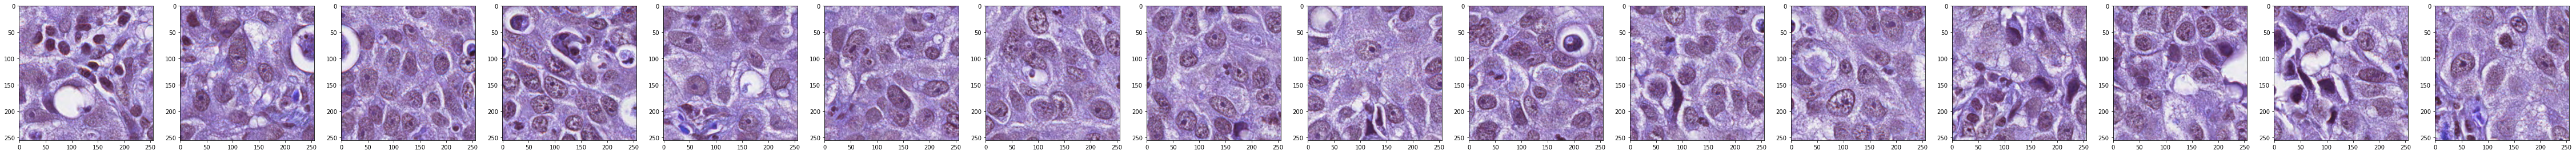

In [19]:
n = cropped_img_array.shape[0]

plt.figure(figsize=(5*n,5))
for i in range(n):
    plt.subplot(1,n,i+1)
    plt.imshow(cropped_img_array[i])
plt.show()

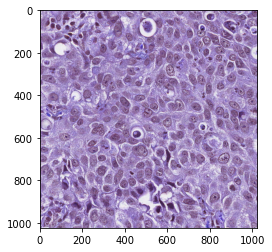

In [20]:
# bandingkan dengan image original
plt.imshow(img_array)
plt.show()

In [21]:
# test dulu 1 mask
mask_array = collect_masks_binary[ind_case] # lihat nilai ind_case di atas
crop_size = determine_split_size(mask_array)
print(crop_size)

256


In [22]:
cropped_mask_array = crop_image(mask_array, crop_size)
print(mask_array.shape) # size mask original
print(cropped_mask_array.shape)

(1024, 1024, 4)
(16, 256, 256, 4)


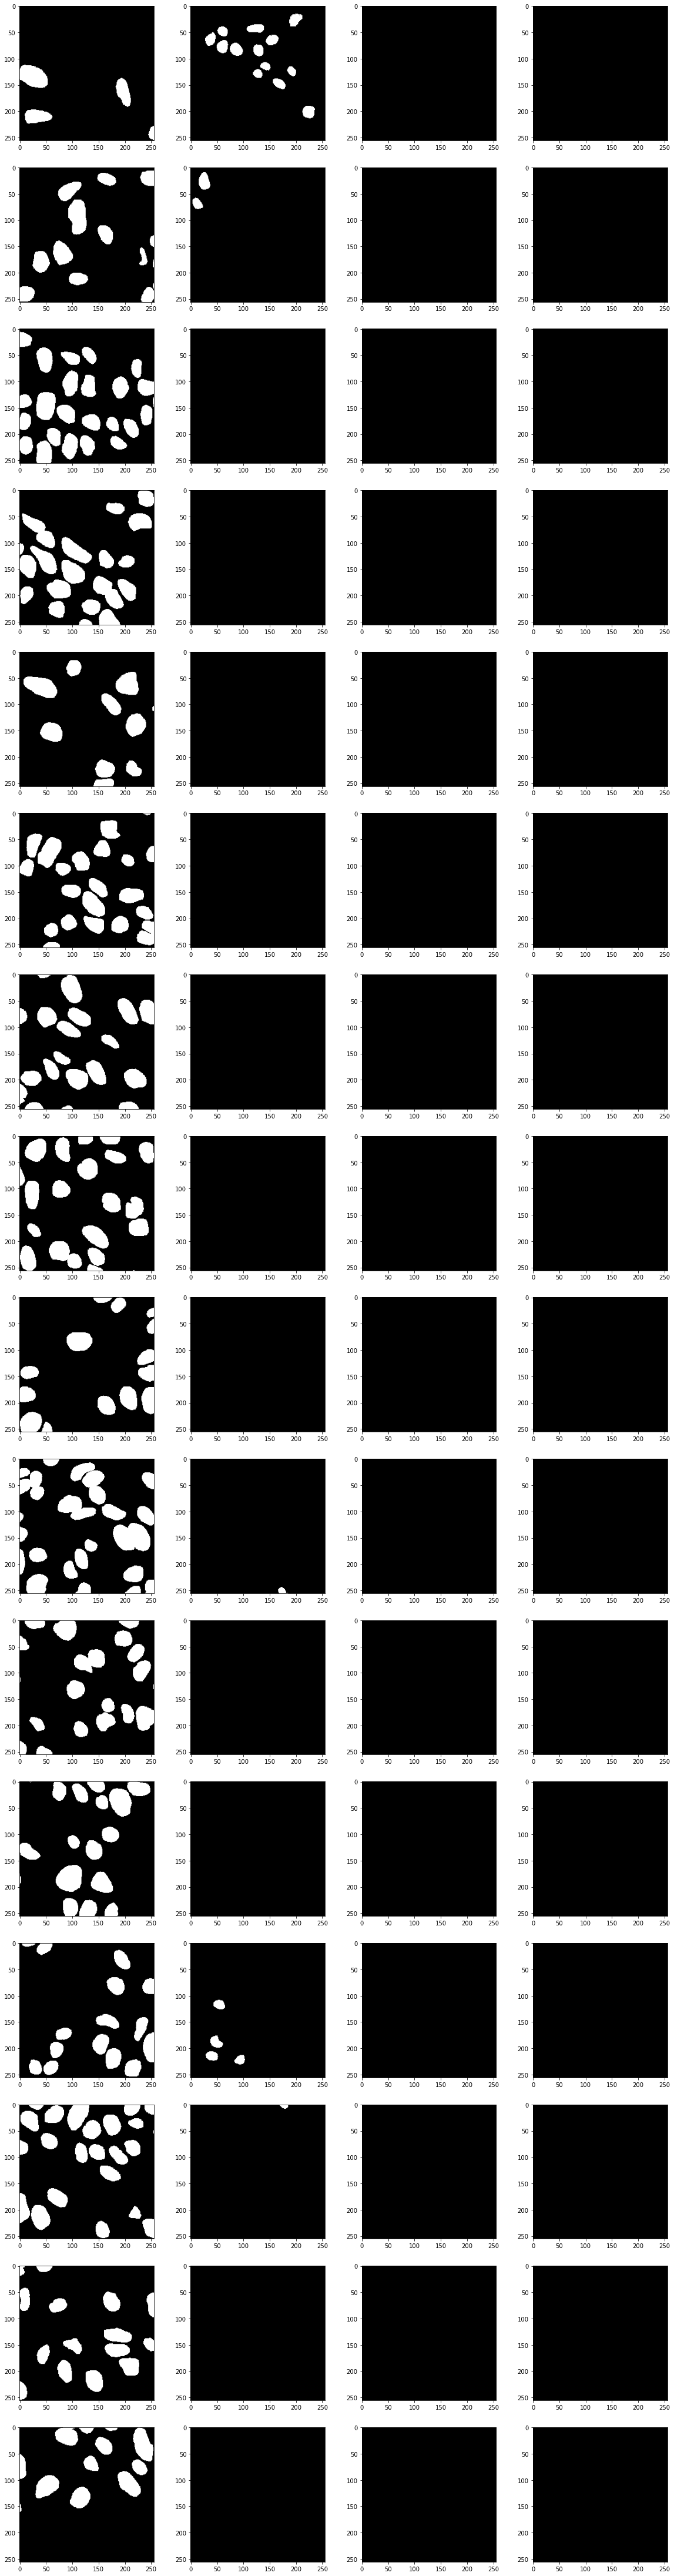

In [23]:
m = cropped_mask_array.shape[0]

plt.figure(figsize=(5*4,5*m))
count=0
for i in range(m):
    for channel in range(4):
        count +=1
        plt.subplot(m, 4, count)
        plt.imshow(cropped_mask_array[i][:,:,channel], cmap='gray')
plt.show()

In [24]:
np.unique(cropped_mask_array)

array([  0, 255], dtype=uint8)

In [25]:
#check value nya
cropped_mask_array[0][110:120,0:10,0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [  0,   0,   0,   0,   0,   0, 255, 255, 255, 255],
       [  0,   0,   0,   0, 255, 255, 255, 255, 255, 255],
       [  0,   0,   0, 255, 255, 255, 255, 255, 255, 255],
       [  0,   0,   0, 255, 255, 255, 255, 255, 255, 255],
       [  0,   0, 255, 255, 255, 255, 255, 255, 255, 255],
       [  0,   0, 255, 255, 255, 255, 255, 255, 255, 255],
       [  0, 255, 255, 255, 255, 255, 255, 255, 255, 255]], dtype=uint8)

In [26]:
# test image lain yang ukurannya lebih kecil
ind_case2 = 75
img_array2 = collect_images[ind_case2]
crop_size2 = determine_split_size(img_array2)
print(img_array2.shape) # size citra original
print(crop_size2)

(173, 194, 3)
128


In [27]:
cropped_img_array2 = crop_image(img_array2, crop_size2) # tetap ada overlap, meskipun diatur overlap=0
print(cropped_img_array2.shape)

(4, 128, 128, 3)


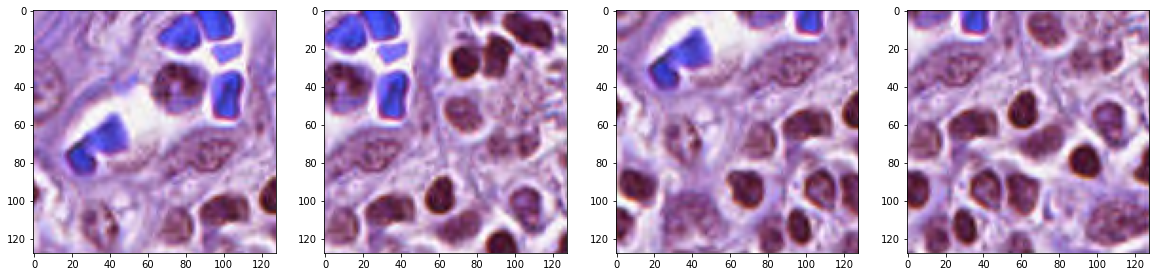

In [28]:
n = cropped_img_array2.shape[0]

plt.figure(figsize=(5*n,5))
for i in range(n):
    plt.subplot(1,n,i+1)
    plt.imshow(cropped_img_array2[i])
plt.show()

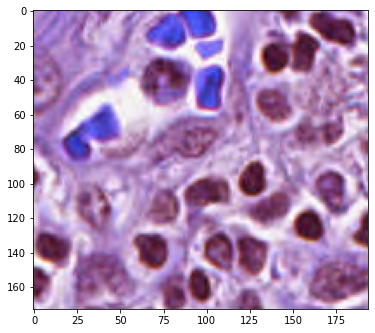

In [29]:
# bandingkan dengan image original
plt.figure(figsize=(6,6))
plt.imshow(img_array2)
plt.show()

In [30]:
cropped_img_array2_resize = resize_multi_image(cropped_img_array2)
cropped_img_array2_resize.shape

(4, 256, 256, 3)

In [31]:
cropped_img_array2_resize[0]

array([[[184, 142, 197],
        [184, 142, 197],
        [185, 143, 199],
        ...,
        [175, 140, 198],
        [173, 136, 197],
        [173, 136, 197]],

       [[184, 142, 197],
        [184, 142, 197],
        [185, 143, 199],
        ...,
        [175, 140, 198],
        [173, 136, 197],
        [173, 136, 197]],

       [[184, 143, 199],
        [184, 143, 199],
        [185, 144, 200],
        ...,
        [176, 140, 199],
        [174, 138, 199],
        [174, 138, 199]],

       ...,

       [[187, 159, 204],
        [187, 159, 204],
        [191, 156, 203],
        ...,
        [240, 225, 249],
        [241, 226, 247],
        [241, 226, 247]],

       [[184, 156, 204],
        [184, 156, 203],
        [188, 152, 201],
        ...,
        [238, 222, 249],
        [240, 226, 248],
        [240, 226, 248]],

       [[184, 156, 204],
        [184, 156, 204],
        [188, 153, 202],
        ...,
        [238, 222, 249],
        [240, 226, 248],
        [240, 226, 248]]

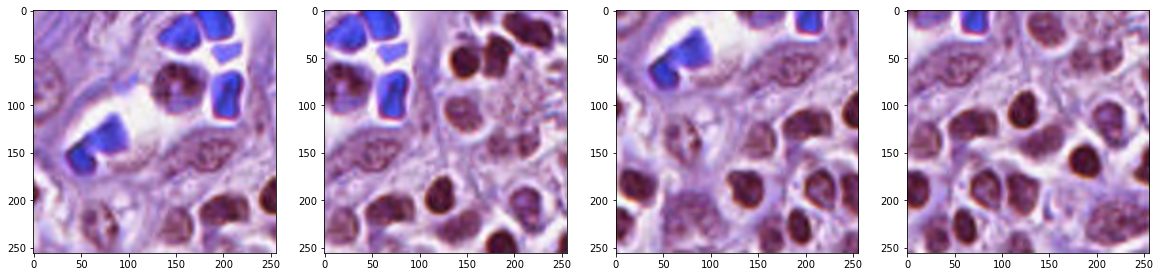

In [33]:
# Plot image yang sdh di-resize
n = cropped_img_array2_resize.shape[0]

plt.figure(figsize=(5*n,5))
for i in range(n):
    plt.subplot(1,n,i+1)
    plt.imshow(cropped_img_array2_resize[i])
plt.show()

In [34]:
# test mask 
# ind_case2 = 75 # sama dengan untuk image
mask_array2 = collect_masks_binary[ind_case2]
crop_size2 = determine
_split_size(mask_array2)
print(mask_array2.shape) # size citra original
print(crop_size2)

(173, 194, 4)
128


In [35]:
cropped_mask_array2 = crop_image(mask_array2, crop_size2) # tetap ada overlap, meskipun diatur overlap=0
print(cropped_mask_array2.shape)

(4, 128, 128, 4)


In [36]:
cropped_mask_array2_resize = resize_multi_image(cropped_mask_array2, thres=127)
cropped_mask_array2_resize.shape

(4, 256, 256, 4)

In [38]:
np.unique(cropped_mask_array2_resize)

array([  0, 255], dtype=uint8)

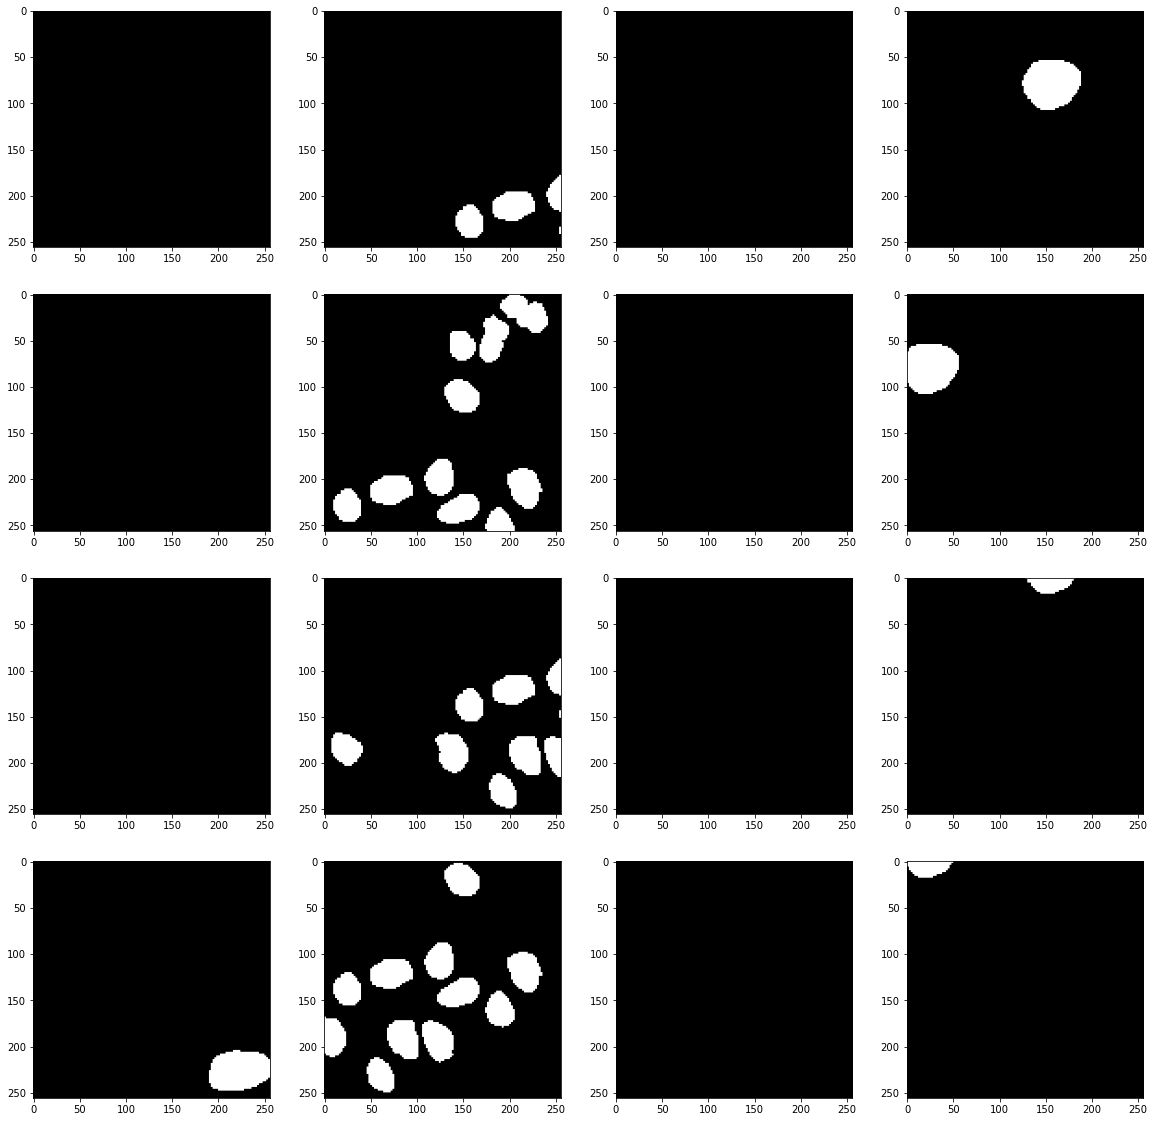

In [39]:
m = cropped_mask_array2_resize.shape[0]

plt.figure(figsize=(5*4,5*m))
count=0
for i in range(m):
    for channel in range(4):
        count +=1
        plt.subplot(m, 4, count)
        plt.imshow(cropped_mask_array2_resize[i][:,:,channel], cmap='gray')
plt.show()

In [35]:
cropped_mask_array2_resize[3][213:218, 192:197,0]

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]], dtype=uint8)

In [36]:
def create_multi_mask_label(mask_binary):
    if len(mask_binary.shape) > 3: # misalnya 4 x 256 x 256 x 4
        combine_label=[]
        for k in range(mask_binary.shape[0]):
            label = create_multi_mask_label(mask_binary[k])
            combine_label.append(label)
        masks_label = np.array(combine_label)
    else:
        masks_label = np.zeros((mask_binary.shape[0], mask_binary.shape[1], 1))
    
        for i in range(4):
            label_code = i+1
            mask = mask_binary[:,:,i]
            mask = np.expand_dims(mask, axis=-1)
            masks_label = np.where(mask==255, label_code, masks_label)
    return masks_label

In [37]:
cropped_mask_array2_resize.shape

(6, 256, 256, 4)

In [38]:
cropped_mask_array2_resize_label = create_multi_mask_label(cropped_mask_array2_resize)
cropped_mask_array2_resize_label.shape

(6, 256, 256, 1)

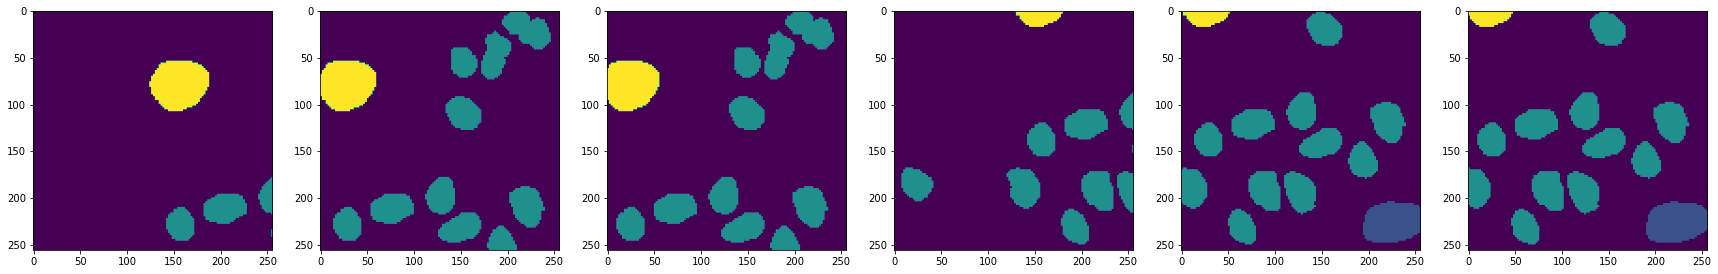

In [39]:
# Plot label yang sdh di-resize
n = cropped_mask_array2_resize_label.shape[0]

plt.figure(figsize=(5*n,5))
for i in range(n):
    plt.subplot(1,n,i+1)
    plt.imshow(cropped_mask_array2_resize_label[i], cmap='viridis')
plt.show()

## Proses semua citra

In [40]:
# dalam format list
print(len(collect_images))
print(len(collect_masks_binary))

209
209


In [41]:
all_data_images=[]
all_data_masks=[]
all_data_labels=[]

#for num in range(6,8): # mengecek image yang memiliki split size yang berbeda
for num in range(len(collect_images)): 
    citra_array = collect_images[num]
    bin_array = collect_masks_binary[num]
    #tentukan ukuran split
    split_size = determine_split_size(citra_array)
    #print('Ukuran crop citra ke-',[num],' :', split_size)
    
    #croppping
    cropped_citra_array = crop_image(citra_array, split_size)
    cropped_bin_array = crop_image(bin_array, split_size)
    #print('Cropped citra size',[num],' :', cropped_citra_array.shape) # mengecek size sebelum di-resize (jika ukuran < 256)
    #print('Cropped mask size',[num],' :', cropped_bin_array.shape)
    
    if split_size != 256:
        cropped_citra_array = resize_multi_image(cropped_citra_array)
        cropped_bin_array = resize_multi_image(cropped_bin_array)
    
    #cek hasil resize
    #print('Cropped citra size',[num],' :', cropped_citra_array.shape) # mengecek size setelah di-resize (jika ukuran < 256)
    #print('Cropped mask size',[num],' :', cropped_bin_array.shape)
    
    cropped_bin_array_label = create_multi_mask_label(cropped_bin_array)
    #print('Labeled mask size',[num],' :', cropped_bin_array_label.shape)
    all_data_images.extend(cropped_citra_array)
    all_data_masks.extend(cropped_bin_array)
    all_data_labels.extend(cropped_bin_array_label)
    #print('')

In [42]:
print(len(all_data_images))
print(len(all_data_masks))
print(len(all_data_labels))

5839
5839
5839


In [43]:
images=np.array(all_data_images)
labels=np.array(all_data_labels)

In [44]:
print(images.shape)
print(labels.shape)

(5839, 256, 256, 3)
(5839, 256, 256, 1)


In [45]:
all_data_images[0].shape

(256, 256, 3)

In [46]:
all_data_masks[0].shape

(256, 256, 4)

In [47]:
all_data_labels[0].shape

(256, 256, 1)

In [48]:
np.unique(labels)

array([0., 1., 2., 3., 4.])

random index = 0


array([0., 1., 2.])

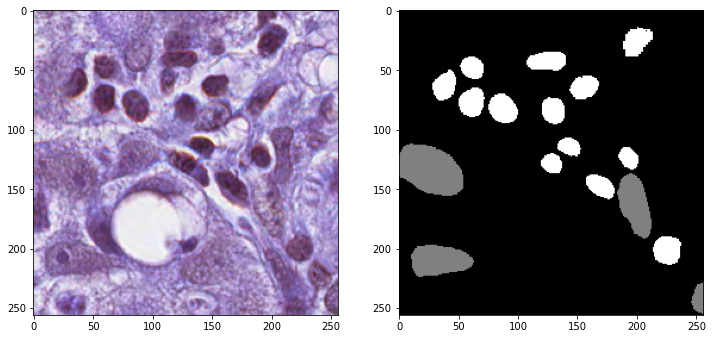

In [49]:
cek_ind = random.randint(0, images.shape[0]-1)
cek_ind=0
print("random index =", cek_ind)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(images[cek_ind]);
ax = fig.add_subplot(1, 2, 2)
ax.imshow(labels[cek_ind], cmap="gray");
np.unique(labels[cek_ind])

In [50]:
labels_cat = to_categorical(labels, num_classes=5)

In [51]:
labels_cat.shape

(5839, 256, 256, 5)

Class yang ada dalam Cell:  [0. 1. 2.]


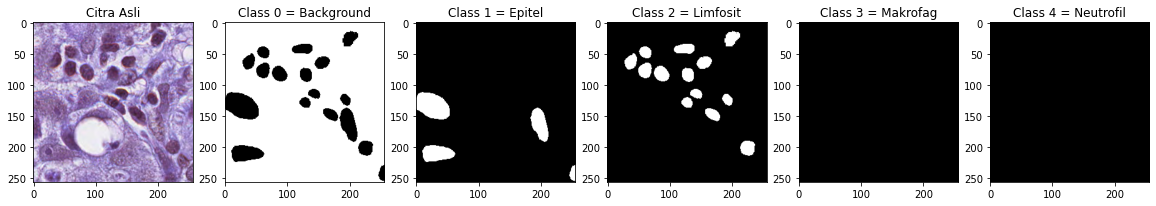

In [52]:
plt.figure(figsize=(20,4))
plt.subplot(1,6,1)
plt.imshow(images[cek_ind]);
plt.title('Citra Asli')
plt.subplot(1,6,2)
plt.imshow(labels_cat[cek_ind][:,:,0], cmap='gray');
plt.title('Class 0 = Background')
plt.subplot(1,6,3)
plt.imshow(labels_cat[cek_ind][:,:,1], cmap='gray');
plt.title('Class 1 = Epitel')
plt.subplot(1,6,4)
plt.imshow(labels_cat[cek_ind][:,:,2], cmap='gray');
plt.title('Class 2 = Limfosit')
plt.subplot(1,6,5)
plt.imshow(labels_cat[cek_ind][:,:,3], cmap='gray');
plt.title('Class 3 = Makrofag')
plt.subplot(1,6,6)
plt.imshow(labels_cat[cek_ind][:,:,4], cmap='gray');
plt.title('Class 4 = Neutrofil')

print("Class yang ada dalam Cell: ", np.unique(labels[cek_ind]))

In [53]:
# simpan data images dan labels dalam format numpy array
np.save('D:/TugasAkhir/DataSet/NPY File/all_images_crop_overlap05.npy', images)
np.save('D:/TugasAkhir/DataSet/NPY File/all_labels_crop_overlap05.npy', labels)
np.save('D:/TugasAkhir/DataSet/NPY File/all_labels_cat_crop_overlap05.npy', labels_cat)